In [1]:
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset, load_dataset

In [2]:
dataset = load_dataset('csv', data_files={'train':['esol_bert_ds1.csv', 'esol_bert_ds2.csv',
                                                   'esol_bert_ds3.csv', 'esol_bert_ds4.csv'],
                                          'validation':'esol_bert_ds5.csv',
                                          'test': 'esol_bert_ds6.csv'}, delimiter=',', column_names =['smiles', 'label'])

Using custom data configuration default-16d340229f74c1d5


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/pj11/.cache/huggingface/datasets/csv/default-16d340229f74c1d5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset['validation'][1]

{'smiles': 'CC34CC(O)C1(F)C(CCC2=CC(=O)C=CC12C)C3CC(O)C4(O)C(=O)CO',
 'label': -3.68}

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("deepchem/ChemBERTa-77M-MTR")

def tokenize_function(examples):
    return tokenizer(examples["smiles"], padding="max_length", truncation=True)

In [5]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 764
    })
    validation: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 190
    })
    test: Dataset({
        features: ['smiles', 'label', 'input_ids', 'attention_mask'],
        num_rows: 190
    })
})

In [7]:
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=random_state).select(range(1000))
#small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=random_state).select(range(1000))

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["validation"]
small_test_dataset = tokenized_datasets["test"]

In [8]:
# for regression, num_labels=1
model = AutoModelForSequenceClassification.from_pretrained("deepchem/ChemBERTa-77M-MTR", num_labels=1)

Some weights of the model checkpoint at deepchem/ChemBERTa-77M-MTR were not used when initializing RobertaForSequenceClassification: ['norm_mean', 'regression.out_proj.weight', 'norm_std', 'regression.out_proj.bias', 'regression.dense.bias', 'regression.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepchem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weig

In [9]:
import evaluate
import numpy as np

In [10]:
mae_metric = evaluate.load("mae")
mse_metric = evaluate.load("mse")
pearsonr_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    # print(eval_pred)
    #logits, labels = eval_pred
    #predictions = np.argmax(logits, axis=-1)
    predictions, labels = eval_pred
    
    metrics = {}
    metrics.update({'mae': mae_metric.compute(predictions=predictions, references=labels)})
    metrics.update({'rmse': mse_metric.compute(predictions=predictions, references=labels, squared=False)})
    metrics.update({'pearsonr': pearsonr_metric.compute(predictions=predictions, references=labels)})
    
    return metrics

In [11]:
para_output_dir = 'C:/Users/pj11/Documents/bert_finetune2/esol_fold1/'
model_output_path = f'{para_output_dir}/model'

training_args = TrainingArguments(output_dir=para_output_dir, 
                                  evaluation_strategy="epoch",
                                  #per_device_train_batch_size = 64,
                                  #per_device_eval_batch_size = 64,
                                  num_train_epochs=50)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [13]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 764
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1200
  Number of trainable parameters = 3427825
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was

Epoch,Training Loss,Validation Loss,Mae,Rmse,Pearsonr
1,No log,12.984365,{'mae': 2.984160893881007},{'mse': 3.613996773981356},{'pearsonr': -0.11209459778270305}
2,No log,9.119222,{'mae': 2.3799418987020067},{'mse': 3.0280281058379046},{'pearsonr': -0.2699275622576053}
3,No log,3.927746,{'mae': 1.5420490744474686},{'mse': 1.9815574817595984},{'pearsonr': 0.5920640524214649}
4,No log,1.750324,{'mae': 1.03072284287528},{'mse': 1.3195232950462024},{'pearsonr': 0.8013015831669301}
5,No log,1.616080,{'mae': 1.0236645638060413},{'mse': 1.2680229551192121},{'pearsonr': 0.8326592459150237}
6,No log,1.389485,{'mae': 0.953807479025502},{'mse': 1.1751459717091104},{'pearsonr': 0.8607159680807849}
7,No log,1.265544,{'mae': 0.9003752521484306},{'mse': 1.1235506921233867},{'pearsonr': 0.8679903853346769}
8,No log,1.093065,{'mae': 0.8382178410936735},{'mse': 1.0430409879614053},{'pearsonr': 0.886021047608962}
9,No log,1.122080,{'mae': 0.8536650743727622},{'mse': 1.0581573086346625},{'pearsonr': 0.8880543567678005}
10,No log,1.094842,{'mae': 0.8415683551446388},{'mse': 1.0446256542651344},{'pearsonr': 0.8938849949933865}


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 190
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 190
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

Saving model checkpoint to C:/Users/pj11/Documents/bert_finetune2/esol_fold1/checkpoint-500
Configuration saved in C:/Users/pj11/Documents/bert_finetune2/esol_fold1/checkpoint-500\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/esol_fold1/checkpoint-500\pytorch_model.bin
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceCla

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 190
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 190
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 190
  Batch size = 32
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\pj11\Anaconda3\envs\my-rdkit-env\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles ar

TrainOutput(global_step=1200, training_loss=1.1795211601257325, metrics={'train_runtime': 171.8749, 'train_samples_per_second': 222.255, 'train_steps_per_second': 6.982, 'total_flos': 351966825062400.0, 'train_loss': 1.1795211601257325, 'epoch': 50.0})

In [14]:
#take care of distributed/paralelle training 
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model 
model_to_save.save_pretrained(model_output_path)

Configuration saved in C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model\config.json
Model weights saved in C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model\pytorch_model.bin


In [15]:
# making prediction 
model = AutoModelForSequenceClassification.from_pretrained(model_output_path)

# arguments for Trainer
test_args = TrainingArguments(
     output_dir =model_output_path,
     do_train = False,
     do_predict = True,
     dataloader_drop_last = False
)

# Init Trainer
trainer=Trainer(
          model = model,
          args = test_args,
          compute_metrics = compute_metrics)

test_results = trainer.predict(small_test_dataset)

loading configuration file C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model\config.json
Model config RobertaConfig {
  "_name_or_path": "C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.109,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.144,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 464,
  "is_gpu": true,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 515,
  "model_type": "roberta",
  "norm_mean": [
    11.199569164274653,
    -0.9728601944583675,
    11.199595401578872,
    0.1914454376660732,
    0.608589373135307,
    365.064017672,
    342.24912812000014,
    364.6033136038417,
    134.06547,
    0.004249,
    0.0,
    0.0,
    0.0,
    0

loading weights file C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model\pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at C:/Users/pj11/Documents/bert_finetune2/esol_fold1//model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `Rob

In [16]:
test_results[1]

array([ 0.61 , -3.083,  0.38 , -1.99 , -6.18 , -4.799, -2.08 , -4.64 ,
       -1.29 , -2.484, -1.37 , -1.06 , -4.345, -0.98 , -2.41 , -3.88 ,
       -2.68 , -3.38 , -7.68 , -2.77 , -2.11 , -3.36 , -2.266, -4.23 ,
       -0.67 ,  0.94 , -3.39 , -2.369, -2.58 , -0.5  , -1.13 , -9.15 ,
       -7.96 , -3.77 , -4.24 , -1.62 , -4.14 , -1.877, -0.4  , -2.92 ,
       -1.25 , -1.85 , -4.47 , -1.09 , -2.37 , -4.873, -3.03 , -4.411,
       -1.92 , -2.03 , -3.504, -3.78 , -2.461, -1.52 , -0.59 , -3.23 ,
       -1.24 , -5.67 , -2.982, -5.736, -2.843, -1.49 , -2.57 , -9.332,
       -3.   , -2.22 , -4.11 , -4.37 , -2.35 , -1.33 , -6.01 , -6.27 ,
       -1.91 , -4.56 , -0.8  , -0.4  , -3.094, -3.4  , -2.25 , -0.12 ,
       -1.72 , -3.324, -0.59 , -0.99 , -3.893, -4.955, -0.74 , -1.06 ,
       -4.13 , -7.43 , -2.93 , -9.16 , -0.6  , -0.8  , -3.7  , -2.943,
       -3.37 , -0.92 , -2.39 , -3.24 , -6.29 , -1.708, -4.48 , -6.26 ,
       -2.67 , -4.679, -2.253, -3.17 , -7.337, -5.184, -2.468, -6.14 ,
      

In [17]:
test_results[2]

{'test_loss': 0.6118962168693542,
 'test_mae': {'mae': 0.6257151697517226},
 'test_rmse': {'mse': 0.7844339503206982},
 'test_pearsonr': {'pearsonr': 0.9451561078776958},
 'test_runtime': 0.9692,
 'test_samples_per_second': 196.036,
 'test_steps_per_second': 6.191}

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(test_results[0], test_results[1]))

#RMSEs
print(math.sqrt(mean_squared_error(test_results[0], test_results[1])))

# R^2 Coefficient of Determination
print(r2_score(test_results[0], test_results[1]))

0.62571514
0.7844339340988442
0.8490492765539396


Text(0, 0.5, 'pred. log S')

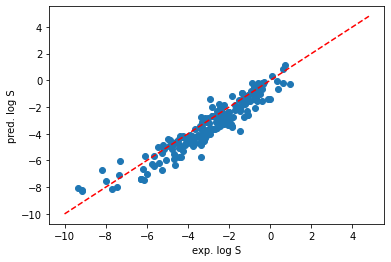

In [19]:
import matplotlib.pyplot as plt
plt.figure(1)

ln = np.arange(-10, 5, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(test_results[1], test_results[0])
plt.xlabel('exp. log S')
plt.ylabel('pred. log S')

In [20]:
pd_pred_test=pd.DataFrame(test_results[0], columns=["predict"])
pd_exp_test=pd.DataFrame(test_results[1], columns=["exp"])
pd_smiles=pd.DataFrame(dataset['test']['smiles'], columns=["smiles"])
pd_test=pd.concat((pd_smiles, pd_exp_test, pd_pred_test), axis=1)

# save predicton to csv 
pd_test.to_csv('esol_bert_ds6_fold1_results.csv')